# El Niño Discovery Using CFL 

This notebook demonstrates how to run Causal Feature Learning (CFL) on the El Niño dataset. 
This dataset is comprised of wind speed (WS) and sea surface temperature (SST) measurements
in a region of the pacific ocean. By looking at the conditional relationship between these two variables, CFL can aggregate these low-level measurements into coarser macrovariables that represent ocean climate phenomena such as El Niño and La Niña SST patterns.



In [2]:
# imports
import os                                               # manage paths
import joblib                                           # load data
from sklearn.preprocessing import StandardScaler        # standardize data
import matplotlib.pyplot as plt                         # visualize data
from mpl_toolkits.axes_grid1 import make_axes_locatable # visualize data
from cfl.experiment import Experiment                   # run CFL
import numpy as np

# constants
WS_CMAP = 'BrBG_r'
SST_CMAP = 'coolwarm'
IMSHAPE = (55, 9)
FIG_PATH = 'el_nino_figures'

### Load Data
First, we load in the data as variables X and Y, and standardize both X and Y to improve
neural network training efficiency. An example sample (WS and SST measurements at the same time point) is plotted below.

In [3]:
# load data
data_path = '../../../data/el_nino/elnino_data.pkl' # set this to your local path to your data
Xraw, Yraw, coords = joblib.load(data_path)
print('Xraw shape: {}'.format(Xraw.shape))
print('Yraw shape: {}'.format(Yraw.shape))

Xraw shape: (13140, 495)
Yraw shape: (13140, 495)


In [4]:
# pacific map plotting helper function
from matplotlib.cm import ScalarMappable

def plot_contour_map(data, ax, imshape, title, cmap, cmap_label, vmin=None, 
                     vmax=None, xlabel='Longitude (°)', ylabel='Latitude (°)'):
    im = ax.contourf(coords['x'].ravel(), coords['y'].ravel(), 
                     data.reshape(imshape).T, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=12)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=12)
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    if vmin is None:
        vmin = np.min(data)
    if vmax is None:
        vmax = np.max(data)
    cb = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax, 
                                     orientation='vertical')
    cb.set_label(label=cmap_label, fontweight='bold', rotation=-90, fontsize=12, 
                 labelpad=15)


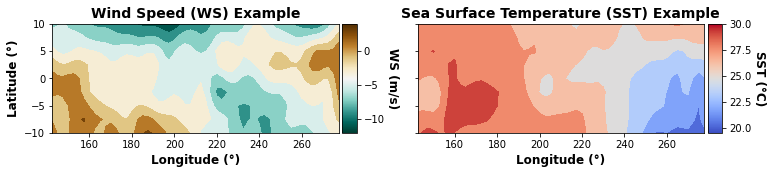

In [4]:
# plot an example WS and SST image pair               
fig,ax = plt.subplots(1, 2, figsize=(12,2), sharex=True, sharey=True)
plot_contour_map(data=Xraw[0], ax=ax[0], imshape=IMSHAPE, 
                 title='Wind Speed (WS) Example', cmap=WS_CMAP, 
                 cmap_label='WS (m/s)')
plot_contour_map(data=Yraw[0], ax=ax[1], imshape=IMSHAPE, 
                 title='Sea Surface Temperature (SST) Example', cmap=SST_CMAP, 
                 cmap_label='SST (°C)',
                 ylabel='')  
plt.savefig(os.path.join(FIG_PATH, 'sample_ws_sst'))
plt.show()

In [6]:
# standardize data
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

### Run CFL

CFL is composed of two main steps. First, a conditional density estimator (CDE) is used to approximate the probability of Y given X. Second, this conditional relationship is clustered to form a partitioning of X and a partitioning of Y. To run CFL, we first set parameters for each of these steps (this is done below in defining `CDE_params` and `cluster_params`).

We can then define an `Experiment` with these parameters and train it to learn a mapping from microvariables to macrovariables. 

In [11]:
# set all CFL parameters

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape,
              'Y_type' : 'continuous'} 

# CDE parameters
lr = 1e-4
CDE_params = { 
               'model'       : 'CondExpMod',
               'batch_size'  : 128,
               'optimizer'   : 'adam',
               'opt_config'  : {'lr': 1e-4},
               'n_epochs'    : 1000,
               'verbose'     : 1,
               'dense_units' : [1024, 1024, data_info['Y_dims'][1]],
               'activations' : ['linear', 'linear', 'linear'],
               'dropouts'    : [0.5, 0.5, 0.0],
               'early_stopping' : True,
               'weights_path'   : 'results/experiment0000/trained_blocks/CDE' }

# clusterer parameters
cause_cluster_params =  {'model' : ['KMeans'],
                         'n_clusters' : range(2,21),
                         'verbose' : 0,
                         'tune' : True}

effect_cluster_params = {'model' : ['KMeans'],
                         'n_clusters' : range(2,21), 
                         'verbose' : 0,
                         'precompute_distances' : True,
                         'tune' : True}

In [13]:
block_names = ['CDE', 'CauseClusterer', 'EffectClusterer']
block_params = [CDE_params, cause_cluster_params, effect_cluster_params]
save_path = 'results'

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, 
                    block_names=block_names, block_params=block_params, 
                    blocks=None, verbose=1, results_path=save_path)

train_results = my_exp.train()

Now that the CFL pipeline has been trained, we can access the results from training in the `train_results` dictionary. Below, we can see that CFL has constructed a labeling of our wind speed data that identifies the macrovariable class that each sample belongs to. 

In [90]:
xlbls = train_results['CauseClusterer']['x_lbls']
ylbls = train_results['EffectClusterer']['y_lbls']

print('X macrovariable states:')
print(np.unique(xlbls))
print('Y macrovariable states:')
print(np.unique(ylbls))

X macrovariable states:
[0 1 2 3 4 5 6 7]
Y macrovariable states:
[0 1 2 3 4 5 6 7]


### Visualize Results

Lastly, we can visualize the macrovariable states CFL discovered by plotting 
the average difference between microvariable samples in each state and the 
global mean.

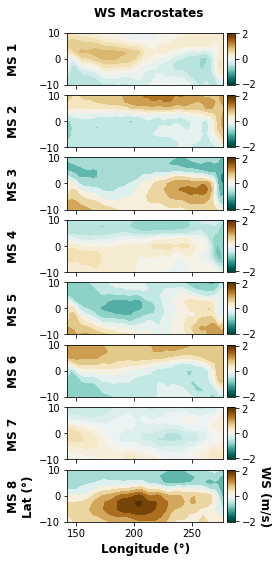

In [91]:
# plot microvariable averages per cause macro-state
nxlbls = len(np.unique(xlbls))
fig,ax = plt.subplots(nxlbls,1, figsize=(3,(nxlbls+1)*1), sharex=True, sharey=True)
means = np.zeros((nxlbls,X.shape[1]))
for i,lbl in enumerate(np.unique(xlbls)):
    means[i] = np.mean(X[xlbls==lbl], axis=0)
bound = np.max(np.abs([np.min(means),np.max(means)]))
vmin,vmax=-bound,bound
for i,lbl in enumerate(np.unique(xlbls)):
    if i==len(np.unique(ylbls))-1:
        xlabel = 'Longitude (°)'
        ylabel = f'MS {lbl+1}\nLat (°)'
        cmap_label = 'WS (m/s)'
    else:
        xlabel = None
        ylabel = f'MS {lbl+1}\n'
        cmap_label = None
    plot_contour_map(data=means[i], 
                     ax=ax[i], 
                     imshape=IMSHAPE, 
                     title=None,
                     cmap=WS_CMAP, 
                     cmap_label=cmap_label,
                     vmin=vmin,
                     vmax=vmax,
                     xlabel=xlabel,
                     ylabel=ylabel)
plt.suptitle('WS Macrostates', y=0.92, fontweight='bold')
plt.savefig(os.path.join(FIG_PATH, 'ws_macrostates'), bbox_inches='tight')
plt.show()

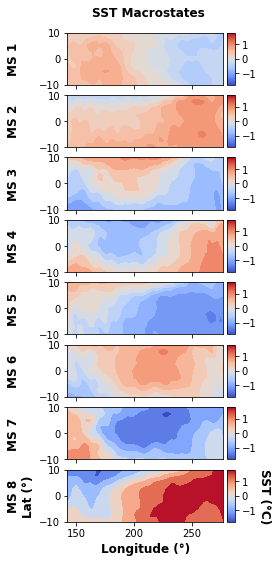

In [92]:
# plot microvariable averages per effect macro-state
nylbls = len(np.unique(ylbls))
fig,ax = plt.subplots(nylbls,1, figsize=(3,(nxlbls+1)*1), sharex=True, sharey=True)
means = np.zeros((nylbls,X.shape[1]))
for i,lbl in enumerate(np.unique(ylbls)):
    means[i] = np.mean(Y[ylbls==lbl], axis=0)
means = means - np.mean(Y,axis=0)
bound = np.max(np.abs([np.min(means),np.max(means)]))
vmin,vmax=-bound,bound
for i,lbl in enumerate(np.unique(ylbls)):
    if i==len(np.unique(ylbls))-1:
        xlabel = 'Longitude (°)'
        ylabel = f'MS {lbl+1}\nLat (°)'
        cmap_label = 'SST (°C)'
    else:
        xlabel = None
        ylabel = f'MS {lbl+1}\n'
        cmap_label = None
    plot_contour_map(data=means[i], 
                     ax=ax[i], 
                     imshape=IMSHAPE, 
                     title=None,
                     cmap=SST_CMAP, 
                     cmap_label=cmap_label,
                     vmin=vmin,
                     vmax=vmax,
                     xlabel=xlabel,
                     ylabel=ylabel)
plt.suptitle('SST Macrostates', y=0.92, fontweight='bold')
plt.savefig(os.path.join(FIG_PATH, 'sst_macrostates'), bbox_inches='tight')
plt.show()

[[1.53846154e-02 2.58461538e-02 9.53846154e-02 0.00000000e+00
  0.00000000e+00 8.44307692e-01 0.00000000e+00 1.90769231e-02]
 [6.34005764e-03 0.00000000e+00 4.72622478e-02 0.00000000e+00
  9.40634006e-01 0.00000000e+00 5.76368876e-03 0.00000000e+00]
 [6.32111252e-03 2.40202276e-02 0.00000000e+00 9.22882427e-01
  6.32111252e-04 6.95322377e-03 1.70670038e-02 2.21238938e-02]
 [9.07787864e-03 9.13521261e-01 0.00000000e+00 3.67892977e-02
  0.00000000e+00 1.33779264e-02 4.77783086e-04 2.67558528e-02]
 [1.70170170e-02 0.00000000e+00 0.00000000e+00 2.50250250e-02
  1.20120120e-02 0.00000000e+00 9.45945946e-01 0.00000000e+00]
 [5.41441066e-03 0.00000000e+00 9.22115785e-01 0.00000000e+00
  4.16493128e-02 3.08204915e-02 0.00000000e+00 0.00000000e+00]
 [7.66160764e-01 5.62113547e-02 3.70994941e-02 3.42889264e-02
  3.65373806e-02 4.10342889e-02 2.86677909e-02 0.00000000e+00]
 [0.00000000e+00 2.15982721e-02 0.00000000e+00 7.55939525e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 9.70842333e-01]]

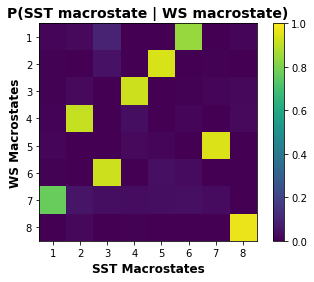

In [26]:
from cfl.post_cfl.macro_cond_prob import compute_macro_cond_prob

P_Ym_given_Xm = compute_macro_cond_prob(data=None, exp='results/experiment0010', 
                                        visualize=False)
print(P_Ym_given_Xm)

# plot macro-level conditional probabilities
fig,ax = plt.subplots()
im = ax.imshow(P_Ym_given_Xm, vmin=0, vmax=1)
ax.set_xlabel('SST Macrostates', fontweight='bold', fontsize=12)
ax.set_ylabel('WS Macrostates', fontweight='bold', fontsize=12)
ax.set_xticks(range(P_Ym_given_Xm.shape[1]))
ax.set_yticks(range(P_Ym_given_Xm.shape[0]))
ax.set_xticklabels(range(1,P_Ym_given_Xm.shape[1]+1))
ax.set_yticklabels(range(1,P_Ym_given_Xm.shape[0]+1))
ax.set_title('P(SST macrostate | WS macrostate)', fontweight='bold', fontsize=14)
fig.colorbar(im)
plt.savefig(os.path.join(FIG_PATH, 'macro_cond_prob'), bbox_inches='tight')
plt.show()

### Label New Data

With a trained CFL pipeline, we can also add new microvariable samples to the Experiment and construct a mapping to the macrovariable representation using `predict`.

For the sake of demonstration, we will just add the dataset we used to train the pipeline here as a new dataset.

In [12]:
# add a new dataset to this experiment's known set of data sets 
my_exp.add_dataset(X=X, Y=Y, dataset_name='dataset_test')

# run the new dataset through the trained cfl pipeline
pred_results = my_exp.predict('dataset_test')

print('X macrovariable states:')
pred_results['CauseClusterer']['x_lbls']

### Microvariable Importance

100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


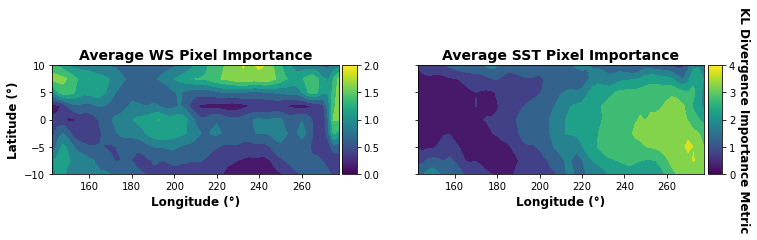

In [23]:
from cfl.post_cfl.microvariable_importance import compute_microvariable_importance

fig,ax = plt.subplots(1,2, figsize=(12,2), sharex=True, sharey=True)
spaces = ['cause', 'effect']
samples = [X, Y]
titles = ['Average WS Pixel Importance', 'Average SST Pixel Importance']
for i in range(2):
    importances = compute_microvariable_importance(
                            exp='results/experiment0010', 
                            data=samples[i], 
                            cause_or_effect=spaces[i])
    if i==0:
        cmap_label = ''
        ylabel='Latitude (°)'
    else:
        cmap_label = 'KL Divergence Importance Metric'
        ylabel=''
    plot_contour_map(data=np.mean(importances,(0,1)), ax=ax[i], imshape=IMSHAPE, 
                    title=titles[i], cmap='viridis', 
                    cmap_label=cmap_label, ylabel=ylabel)
plt.savefig('results/experiment0010/dataset_train/importance_maps', 
            bbox_inches='tight')
            

## Intervention Recommendation

array([0., 0., 0., ..., 0., 0., 0.])

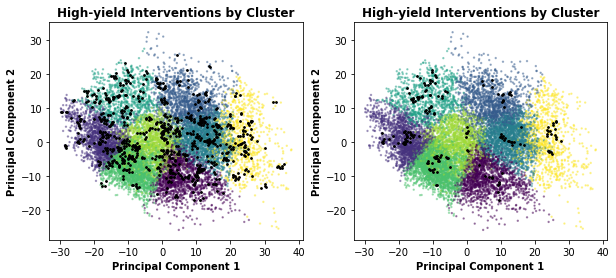

In [1]:
# from cfl.post_cfl.intervention_rec import get_recommendations
import cfl.post_cfl.intervention_rec as ir 
from importlib import reload
reload(ir)

ir.get_recommendations(exp='results/experiment0010', data=None, 
                         dataset_name='dataset_train', 
                         cause_or_effect='cause', visualize=True, k_samples=100,
                         eps=0.5)


### References 

This notebook is based on a notebook created by Krzysztof Chalupka in 2016: http://people.vision.caltech.edu/~kchalupk/code.html